# IYT index ETF constrction
**Author: Yuzhou Liu, Qinhan Shen, Hang Xu, Jiaren Ma**

## Introduction
asdjfkhajksdfhajksdhfkajsdhfkja sdbkjsdbvkjdsbvkashv sdajakfhasd jbv dsaf 
asdf khsaf dsa

## Data Preparation

In [1]:
# Packages used
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from itertools import combinations
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 
import datetime 
import warnings
warnings.filterwarnings("ignore")

# Load module with utility functions, including optimization
import risk_opt_2Student as riskopt 

In [2]:
# Functions
def getDataBatch(tickers, startdate, enddate):
  def getData(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map(getData, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

def getAdjPrice(tickers, start_dt, end_dt): 
    px_data = getDataBatch(tickers, start_dt, end_dt)
    px = px_data[['Adj Close']]
    return(px)

def getReturn(tickers, start_dt, end_dt): 
    px_data = getDataBatch(tickers, start_dt, end_dt)
    Ret = px_data[['Adj Close']].reset_index().pivot(index='Date', columns='Ticker', values='Adj Close').pct_change().dropna()
    return(Ret)

In [3]:
# get the Index Component
IYT_comp = pd.read_csv('IYTcomp.csv')
Tickers= IYT_comp['Ticker']
W_b = IYT_comp['Weight'].as_matrix()
IYT_comp = pd.Series(W_b, index = Tickers)

# define the time period 
start_dt = datetime.datetime(2008, 12, 31)
end_dt = datetime.datetime(2018, 12, 31)

# Get Historial returns
Flag_downloadData = False

if Flag_downloadData:
    Returns = getReturn(Tickers,start_dt, end_dt)
    Return_index = getReturn(['IYT'],start_dt, end_dt)
    Return_index = Return_index.loc['IYT']
    Level_index = getAdjPrice(['IYT'],start_dt, end_dt)
    Level_index = Level_index.loc['IYT']
    scale = 100
    Returns = Returns*scale
    Return_index = Return_index*scale
    Level_index.to_csv('IYTIndex.csv')
    Return_index.to_csv('IYTIndexRe.csv')
    Returns.to_csv('IYTcompRe.csv')

else:
    Returns = pd.read_csv('IYTcompRe.csv')
    Date = pd.to_datetime(Returns['Date'])
    Returns = Returns.iloc[:,1:].set_index(Date)
    Return_index = pd.read_csv('IYTIndexRe.csv',index_col=0)
    Return_index =  Return_index.set_index(Date)
    Level_index = pd.read_csv('IYTIndex.csv')
    Date = pd.to_datetime(Level_index['Date'])
    Level_index =  Level_index.iloc[:,1:].set_index(Date)

n_periods, n_stock = Returns.shape

## Date Vis

**Insides from the data**

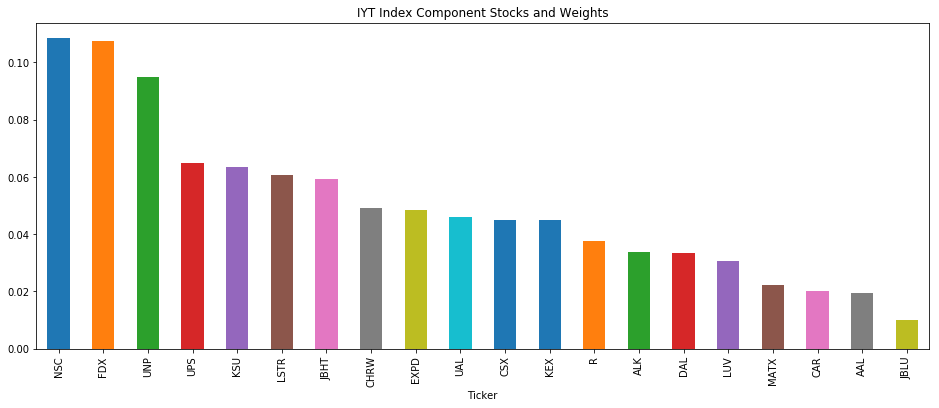

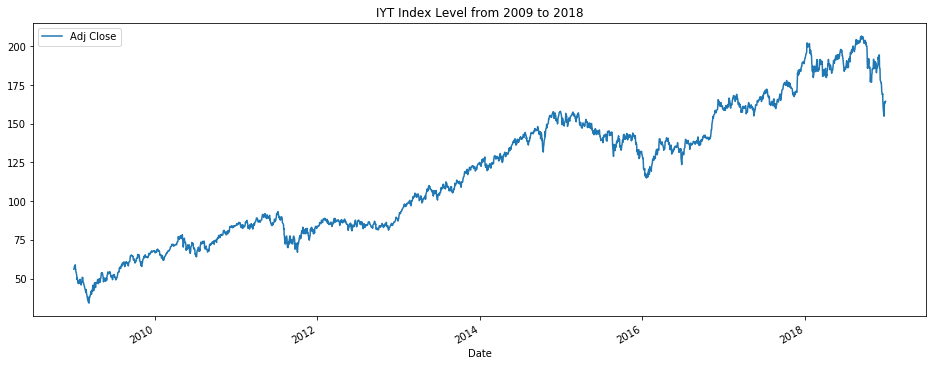

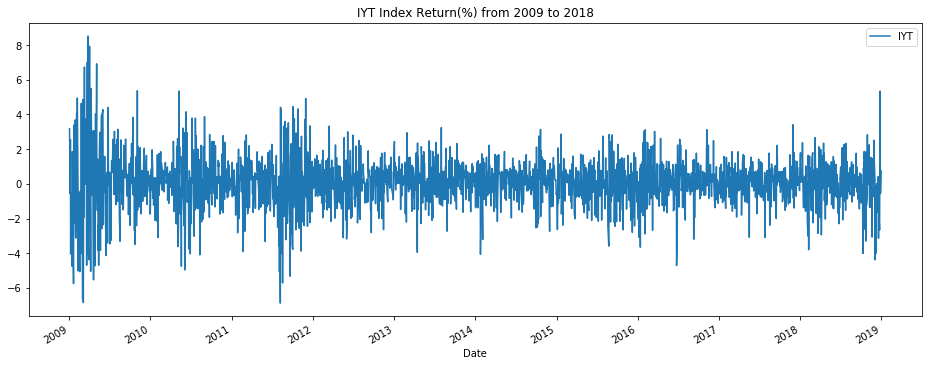

In [4]:
IYT_comp.plot(kind='bar', title='IYT Index Component Stocks and Weights',figsize=(16,6))
Level_index.plot(title='IYT Index Level from 2009 to 2018',figsize=(16,6))
Return_index.plot(title='IYT Index Return(%) from 2009 to 2018',figsize=(16,6))

## Get Best Train and Test Set
The key is find the seprate where two sets have similar distributions

In [5]:
# Use KS test to determine which train/test seperation have most similar distribtuions.
pvlaue = np.zeros(6)
for i in range(2012,2018):
    Trainset = Return_index[Return_index.index <= datetime.datetime(i, 12, 31)]
    Testset = Return_index[(Return_index.index > datetime.datetime(i, 12, 31))]
    ks_test = scipy.stats.ks_2samp(Trainset['IYT'],Testset['IYT'])
    pvlaue[i-2012] = ks_test[1]
    

[Text(0,0.5,'pvlaue'),
 Text(0.5,0,'Train/Test Separation'),
 Text(0.5,1,'KS test to Determine Which Train/Test Separation')]

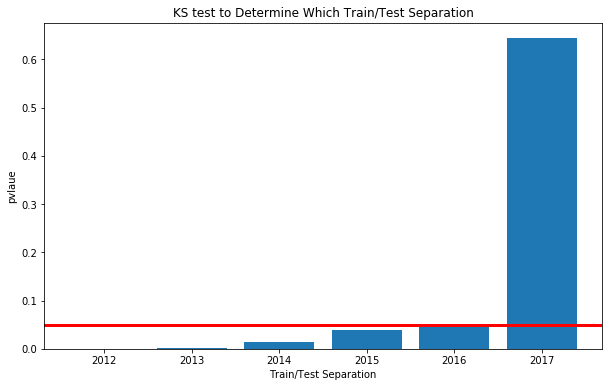

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(2012,2018),height = pvlaue)
ax.axhline(y = 0.05, color = "red", linewidth = 3)
ax.set(title = "KS test to Determine Which Train/Test Separation", 
       xlabel = "Train/Test Separation", ylabel = "pvlaue" )

From the Chart we can see that the best Separation is at 2017,12,31

## Static ETF Weights
**One time train and test sets, and ETF weight keep stable**

In [7]:
# Demean the returns
rets_mean = Returns.mean()
Returns = Returns - rets_mean
# Aline Col
col = Tickers.tolist()
Returns = Returns[col]

In [8]:
#Set Train and Test 
Trainset = Returns[Returns.index <= datetime.datetime(2017, 12, 31)]
Testset = Returns[Returns.index > datetime.datetime(2017, 12, 31)]

In [9]:
lamda = 0.94
var_ewma = riskopt.ewma_cov(Trainset, lamda)
cov_end = var_ewma[-1,:]*252
cov_MA = Trainset.cov()*252
cov_Re = Testset.cov()*252

In [10]:
Must_comp = ['NSC','FDX', 'UNP','UPS','KSU','LSTR','JBHT']
W_star=[]
TE_star_test = np.zeros(9)
TE_star_train = np.zeros(9)
for num_pick in range(7,16):
    Portfolio = list(combinations(Tickers[7:],num_pick-7))
    W_list = []
    TE = []
    Cov_train = cov_MA
    Cov_test = cov_Re
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })
    for i in Portfolio:
        i = list(i)
        i.extend(Must_comp)
        b_ = []
        for j in Tickers:
            if j in i:
                b = (0.0,1.0)
            else:
                b = (0.0,0.0)
            b_.append(b)
        W_TE_min = riskopt.opt_min_te(W_b,Cov_train,b_,c_)
        TE_min = riskopt.obj_te(W_TE_min,W_b,Cov_train)
        TE.append(TE_min)
        W_list.append(W_TE_min)
    TE = np.array(TE)
    W_star.append(W_list[np.argmin(TE)])
    TE_star_train[num_pick-7] = min(TE)
    TE_star_test[num_pick-7] = riskopt.obj_te(W_star[num_pick-7],W_b,Cov_test)
    

In [13]:
# Scale back
TE_star_test_MA = TE_star_test*100
TE_star_train_MA = TE_star_train*100
#W_MA = W_star
#MA_result = pd.DataFrame(W_MA)
#MA_result = MA_result.T
#MA_result = MA_result.append(pd.Series(TE_star_train_MA),ignore_index=True)
#MA_result = MA_result.append(pd.Series(TE_star_test_MA),ignore_index=True)
#MA_result.columns = range(7,16)
#Temp = ["TEinTrain","TEinTest"]
#Index = list(Tickers)
#Index.extend(Temp)
#MA_result.index = Index
#MA_result.to_csv("MAresult.csv")

[Text(0,0.5,'TE in bps'),
 Text(0.5,0,'Num of Component Stock picked'),
 Text(0.5,1,'ETF Strategy based on MA estimated Cov_Matrix')]

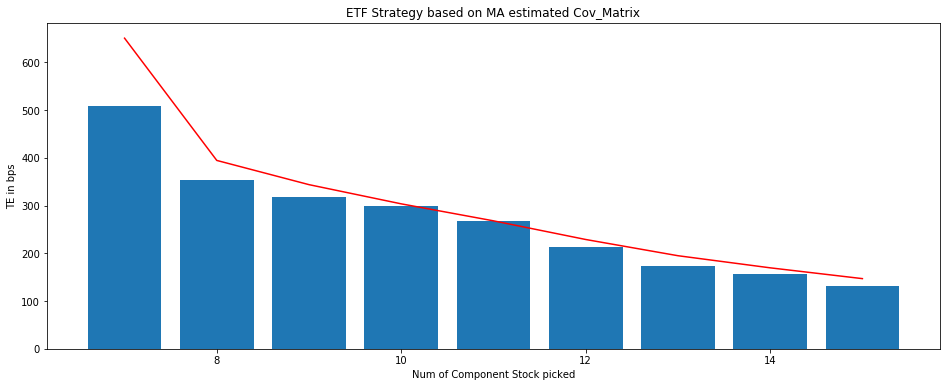

In [12]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(range(7,16),height = TE_star_test_MA)
ax.plot(range(7,16),TE_star_train_MA, color = 'red')
ax.set(title = "ETF Strategy based on MA estimated Cov_Matrix", 
       xlabel = "Num of Component Stock picked", ylabel = "TE in bps" )

In [14]:
Must_comp = ['NSC','FDX', 'UNP','UPS','KSU','LSTR','JBHT']
W_star=[]
TE_star_test = np.zeros(9)
TE_star_train = np.zeros(9)
for num_pick in range(7,16):
    Portfolio = list(combinations(Tickers[7:],num_pick-7))
    W_list = []
    TE = []
    Cov_train = cov_end
    Cov_test = cov_Re
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })
    for i in Portfolio:
        i = list(i)
        i.extend(Must_comp)
        b_ = []
        for j in Tickers:
            if j in i:
                b = (0.0,1.0)
            else:
                b = (0.0,0.0)
            b_.append(b)
        W_TE_min = riskopt.opt_min_te(W_b,Cov_train,b_,c_)
        TE_min = riskopt.obj_te(W_TE_min,W_b,Cov_train)
        TE.append(TE_min)
        W_list.append(W_TE_min)
    TE = np.array(TE)
    W_star.append(W_list[np.argmin(TE)])
    TE_star_train[num_pick-7] = min(TE)
    TE_star_test[num_pick-7] = riskopt.obj_te(W_star[num_pick-7],W_b,Cov_test)
    

In [17]:
# Scale back
TE_star_test_ewma = TE_star_test*100
TE_star_train_ewma = TE_star_train*100
W_ewma = W_star
#EWMA_result = pd.DataFrame(W_ewma)
#EWMA_result = EWMA_result.T
#EWMA_result = EWMA_result.append(pd.Series(TE_star_train_ewma),ignore_index=True)
#EWMA_result = EWMA_result.append(pd.Series(TE_star_test_ewma),ignore_index=True)
#EWMA_result.columns = range(7,16)
#Temp = ["TEinTrain","TEinTest"]
#Index = list(Tickers)
#Index.extend(Temp)
#EWMA_result.index = Index
#EWMA_result.to_csv("EWMAresult.csv")

[Text(0,0.5,'TE in bps'),
 Text(0.5,0,'Num of Component Stock picked'),
 Text(0.5,1,'ETF Strategy based on EWMA estimated Cov_Matrix')]

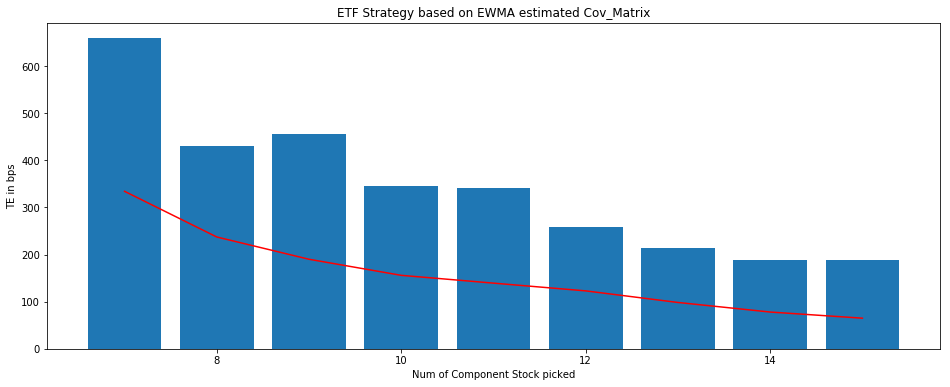

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(range(7,16),height = TE_star_test_ewma)
ax.plot(range(7,16),TE_star_train_ewma, color = 'red')
ax.set(title = "ETF Strategy based on EWMA estimated Cov_Matrix", 
       xlabel = "Num of Component Stock picked", ylabel = "TE in bps" )

**Conclusion from stock component Choice**

14-15

## Dynamic ETF Strategy with monthly Rebalance
**Monthly recalculate the best weight from train set and adjust ETF Component Weights**

## ETF based on EWMA estimator

In [90]:
Window = 90
roll = 30

In [91]:
t_begin = datetime.datetime(2017,12,31)
t_end = t_begin + datetime.timedelta(days = Window)
W_star_ewma_roll = []
TE_train_ewma_roll = np.zeros(10)
TE_test_ewma_roll = np.zeros(10)
for a in range(10):
    train_roll = Returns.loc[:t_begin]
    test_roll = Returns.loc[t_begin:t_end]
    t_begin = t_begin + datetime.timedelta(days = roll)
    t_end = t_end + datetime.timedelta(days = roll)
    var_ewma = riskopt.ewma_cov(train_roll, lamda)
    cov_end = var_ewma[-1,:]*252
    cov_MA = train_roll.cov()*252
    cov_Re = test_roll.cov()*252
    W_list = []
    TE = []
    for num_pick in range(14,16):
        Portfolio = list(combinations(Tickers[7:],num_pick-7))
        Cov_train = cov_end
        Cov_test = cov_Re
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })
        for i in Portfolio:
            i = list(i)
            i.extend(Must_comp)
            b_ = []
            for j in Tickers:
                if j in i:
                    b = (0.0,1.0)
                else:
                    b = (0.0,0.0)
                b_.append(b)
            W_TE_min = riskopt.opt_min_te(W_b,Cov_train,b_,c_)
            TE_min = riskopt.obj_te(W_TE_min,W_b,Cov_train)
            TE.append(TE_min)
            W_list.append(W_TE_min)
    TE = np.array(TE)
    W_star_ewma_roll.append(W_list[np.argmin(TE)])
    TE_train_ewma_roll[a] = min(TE)
    TE_test_ewma_roll[a] =  riskopt.obj_te(W_star_ewma_roll[a],W_b,cov_Re)

**Output to csv files**

In [ ]:
#TE_train_ewma_roll = TE_train_ewma_roll*100
#TE_test_ewma_roll = TE_test_ewma_roll*100
#EWMA_result_roll = pd.DataFrame(W_star_ewma_roll)
#EWMA_result_roll = EWMA_result_roll.T
#EWMA_result_roll = EWMA_result_roll.append(pd.Series(TE_train_ewma_roll),ignore_index=True)
#EWMA_result_roll = EWMA_result_roll.append(pd.Series(TE_test_ewma_roll),ignore_index=True)
#Temp = ["TEinTrain","TEinTest"]
#Index = list(Tickers)
#Index.extend(Temp)
#EWMA_result_roll.index = Index
#EWMA_result_roll.to_csv("EWMAresultRoll.csv")

**Result Vis**

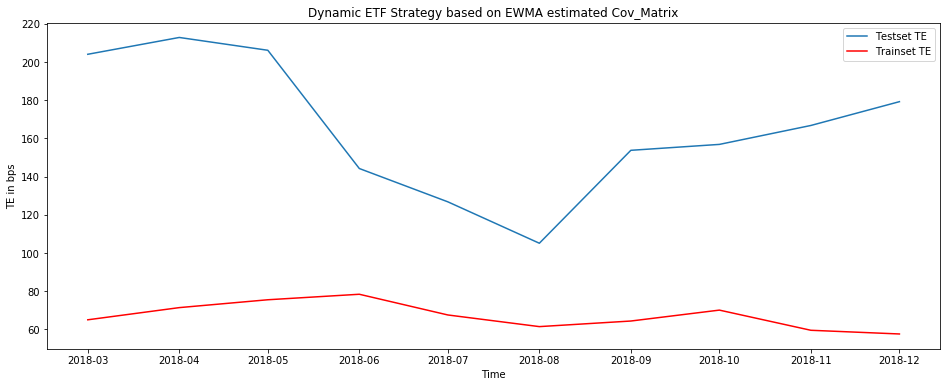

In [107]:
T = [datetime.datetime(2018,i,1) for i in range(3,13)]
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(T,TE_test_ewma_roll, label = 'Testset TE')
ax.plot(T,TE_train_ewma_roll, color = 'red', label = 'Trainset TE')
ax.set(title = "Dynamic ETF Strategy based on EWMA estimated Cov_Matrix", 
       xlabel = "Time", ylabel = "TE in bps" )
ax.legend()

### ETF based on MA estimator

In [108]:
t_begin = datetime.datetime(2017,12,31)
t_end = t_begin + datetime.timedelta(days = Window)
W_star_ma_roll = []
TE_train_ma_roll = np.zeros(10)
TE_test_ma_roll = np.zeros(10)
for a in range(10):
    train_roll = Returns.loc[:t_begin]
    test_roll = Returns.loc[t_begin:t_end]
    t_begin = t_begin + datetime.timedelta(days = roll)
    t_end = t_end + datetime.timedelta(days = roll)
    cov_MA = train_roll.cov()*252
    cov_Re = test_roll.cov()*252
    W_list = []
    TE = []
    for num_pick in range(14,16):
        Portfolio = list(combinations(Tickers[7:],num_pick-7))
        Cov_train = cov_MA
        Cov_test = cov_Re
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })
        for i in Portfolio:
            i = list(i)
            i.extend(Must_comp)
            b_ = []
            for j in Tickers:
                if j in i:
                    b = (0.0,1.0)
                else:
                    b = (0.0,0.0)
                b_.append(b)
            W_TE_min = riskopt.opt_min_te(W_b,Cov_train,b_,c_)
            TE_min = riskopt.obj_te(W_TE_min,W_b,Cov_train)
            TE.append(TE_min)
            W_list.append(W_TE_min)
    TE = np.array(TE)
    W_star_ma_roll.append(W_list[np.argmin(TE)])
    TE_train_ma_roll[a] = min(TE)
    TE_test_ma_roll[a] =  riskopt.obj_te(W_star_ma_roll[a],W_b,cov_Re)

**Output to csv files**

In [111]:
#TE_train_ma_roll = TE_train_ma_roll*100
#TE_test_ma_roll = TE_test_ma_roll*100
#MA_result_roll = pd.DataFrame(W_star_ma_roll)
#MA_result_roll = MA_result_roll.T
#MA_result_roll = MA_result_roll.append(pd.Series(TE_train_ma_roll),ignore_index=True)
#MA_result_roll = MA_result_roll.append(pd.Series(TE_test_ma_roll),ignore_index=True)
#Temp = ["TEinTrain","TEinTest"]
#Index = list(Tickers)
#Index.extend(Temp)
#MA_result_roll.index = Index
#MA_result_roll.to_csv("MAresultRoll.csv")

**Result Vis**

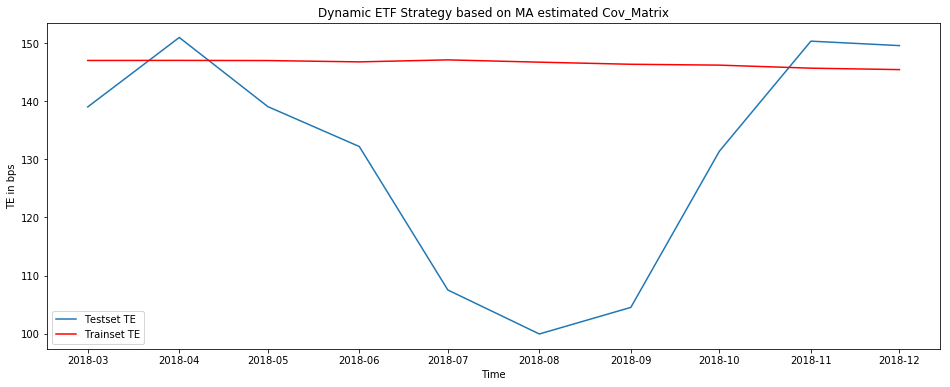

In [112]:
T = [datetime.datetime(2018,i,1) for i in range(3,13)]
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(T,TE_test_ma_roll, label = 'Testset TE')
ax.plot(T,TE_train_ma_roll, color = 'red', label = 'Trainset TE')
ax.set(title = "Dynamic ETF Strategy based on MA estimated Cov_Matrix", 
       xlabel = "Time", ylabel = "TE in bps" )
ax.legend()